In [1]:
# !uv add langgraph

!pip install -U langgraph
!pip install -U langchain
!pip install langchain-openai openai
!pip install langchain-deepseek

Looking in indexes: https://mirrors.cloud.aliyuncs.com/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.9/469.9 kB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.3/399.3 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.4/207.4 kB 58.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 18.0 MB/s eta 0:00:00
DEPRECATION: pytorch-lightning 1.7.7 has a non-standard dependency specifier torch>=1.9.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pytorch-lightning or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/

In [72]:
import os
from langchain.tools import tool, ToolRuntime
from langchain_openai import ChatOpenAI


# 设置 DeepSeek 的 API 密钥（LangChain-OpenAI 仍然会查找 OPENAI_API_KEY）
os.environ['DEEPSEEK_API_KEY'] = 'your_deepseek_api_key_here'

# 您可以尝试将 DEEPSEEK_API_KEY 的值赋给 OPENAI_API_KEY 环境变量
os.environ["OPENAI_API_KEY"] = os.getenv('DEEPSEEK_API_KEY') # 确保这个值是 DeepSeek 的 key

# 关键：指定 DeepSeek 的 API 基础 URL
DEEPSEEK_BASE_URL = "https://api.deepseek.com/v1"

model = ChatOpenAI(
    model="deepseek-chat", # 使用 DeepSeek 的模型名称
    openai_api_base=DEEPSEEK_BASE_URL, # 指定 DeepSeek 的 URL
    temperature=0.7
)

# os.environ["OPENAI_API_KEY"]

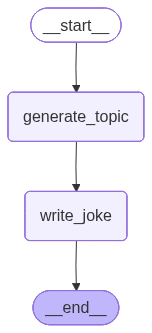

In [73]:
import uuid

from typing_extensions import TypedDict, NotRequired
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    topic: NotRequired[str]
    joke: NotRequired[str]



def generate_topic(state: State):
    """LLM call to generate a topic for the joke"""
    msg = model.invoke("Give me a funny topic for a joke")
    return {"topic": msg.content}


def write_joke(state: State):
    """LLM call to write a joke based on the topic"""
    msg = model.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_topic", generate_topic)
workflow.add_node("write_joke", write_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_topic")
workflow.add_edge("generate_topic", "write_joke")
workflow.add_edge("write_joke", END)

# Compile
checkpointer = InMemorySaver()
graph = workflow.compile(checkpointer=checkpointer)
graph

In [ ]:
config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}
state = graph.invoke({}, config)

print(state["topic"])
print()
print(state["joke"])

In [75]:
# The states are returned in reverse chronological order.
states = list(graph.get_state_history(config))

for state in states:
    print(state.next)
    print(state.config["configurable"]["checkpoint_id"])
    print()

()
1f0b9857-246a-6cba-8002-a1f282a5d0a4

('write_joke',)
1f0b9857-00c1-6232-8001-a5b56c2f1216

('generate_topic',)
1f0b9856-5532-6a3a-8000-4cac45c6e0d8

('__start__',)
1f0b9856-5530-6c8d-bfff-79b5e64881e4



In [76]:
# This is the state before last (states are listed in chronological order)
selected_state = states[1]
print(selected_state.next)
print(selected_state.values)

('write_joke',)
{'topic': 'Of course! Here are a few funny topics that are reliable gold mines for a good joke:\n\n**1. The Unreliable Autocorrect.** It\'s a universal experience that always leads to awkward and hilarious misunderstandings.\n\n*   *Example Setup:* "My phone\'s autocorrect is trying to get me arrested. I tried to text my mom \'I\'m making a quiche\' and it changed it to..."\n\n**2. The Inner Monologue of a Dog.** They are loyal, simple-minded, and obsessed with food. Their perspective on our human world is pure comedy.\n\n*   *Example Setup:* "You can tell exactly what a dog is thinking. When I dropped a piece of chicken, my dog\'s face went from \'I am a noble beast\' to \'I WILL SELL MY SOUL FOR THAT\' in half a second."\n\n**3. The Dreaded Group Project.** Everyone has suffered through one. The dynamic of the over-achiever, the slacker, and the one who just ghosts the group is instantly relatable and funny.\n\n*   *Example Setup:* "Our group project has three types o